<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Part.3/6.Time_Series_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 예제 6-1. 간단한 예측 방법 예시

### 연간 태양 흑점 개수 데이터 예측

#### 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

#### 데이터 전처리

In [ ]:
sunspot = sm.datasets.sunspots.load_pandas().data
sunspot.index = sunspot['YEAR']
sunspot = sunspot.drop(columns='YEAR')
forecast_start = 1997.0
sunspot

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0
...,...
2004.0,40.4
2005.0,29.8
2006.0,15.2


#### Naive forecasting

In [4]:
sunspot['Naive'] = sunspot.loc[forecast_start - 1, 'SUNACTIVITY']

#### Naive seasonal forecasting

In [5]:
seasonality = 10
sunspot['Naive_Seasonal'] = sunspot.loc[:,'SUNACTIVITY'].shift(seasonality)

#### Mean method

In [6]:
sunspot['Mean'] = sunspot.loc[:forecast_start,'SUNACTIVITY'].mean()

#### 예측

In [7]:
forecast_start = 1997
naive_mask = (sunspot.index >= forecast_start)
naive_seasonal_mask = (sunspot.index >= forecast_start)
mean_mask = (sunspot.index >= forecast_start)

#### 시각화

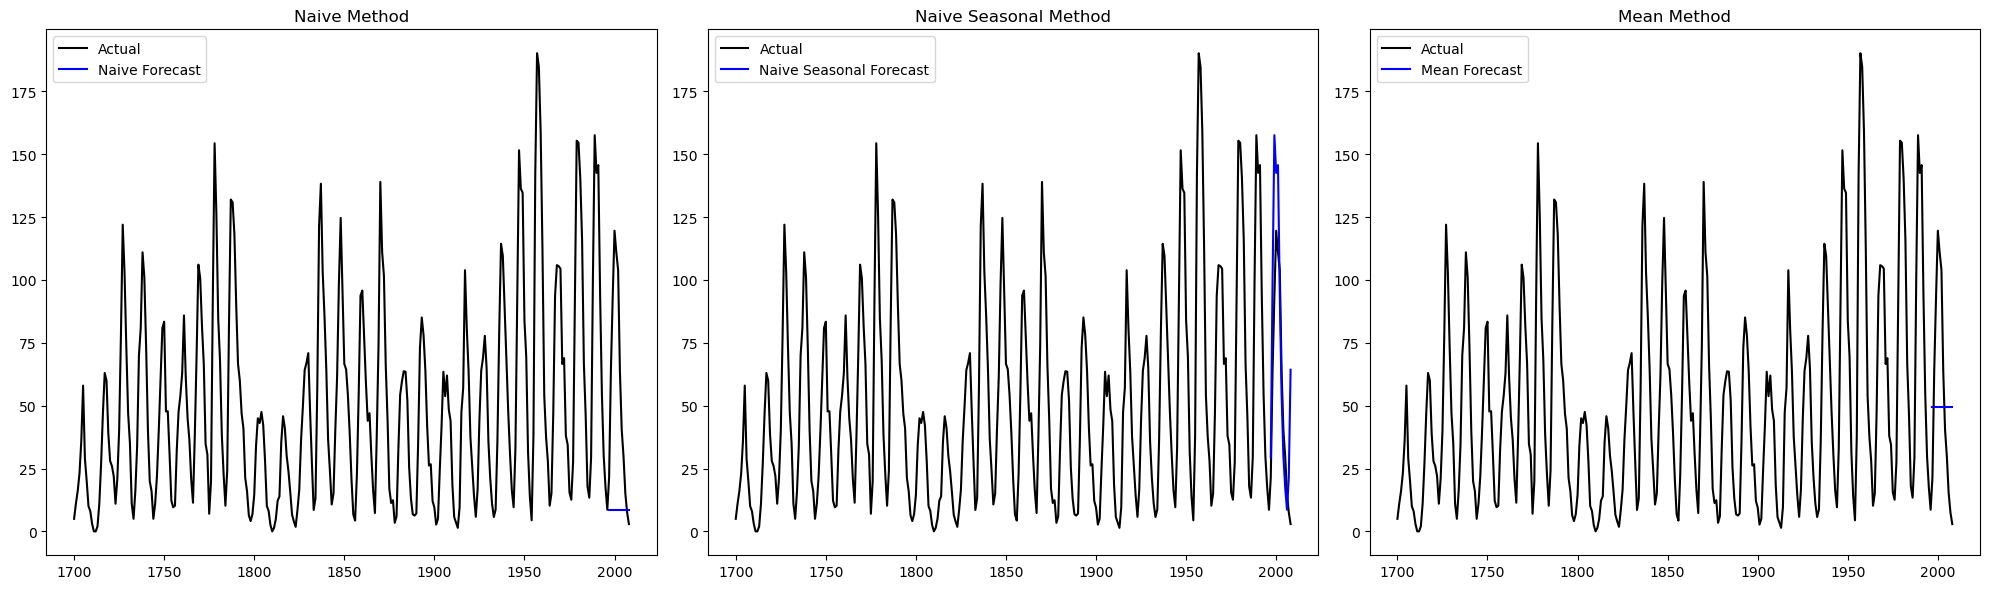

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(sunspot['SUNACTIVITY'], label='Actual', color='black')
plt.plot(sunspot.index[naive_mask], sunspot['Naive'][naive_mask], label='Naive Forecast', color='blue')
plt.title('Naive Method')
plt.legend()

plt.subplot(132)
plt.plot(sunspot['SUNACTIVITY'], label='Actual', color='black')
plt.plot(sunspot.index[naive_seasonal_mask], sunspot['Naive_Seasonal'][naive_seasonal_mask], label='Naive Seasonal Forecast', color='blue')
plt.title('Naive Seasonal Method')
plt.legend()

plt.subplot(133)
plt.plot(sunspot['SUNACTIVITY'], label='Actual', color='black')
plt.plot(sunspot.index[mean_mask], sunspot['Mean'][mean_mask], label='Mean Forecast', color='blue')
plt.title('Mean Method')
plt.legend()

plt.tight_layout()
plt.show()

## 예제 6-2. 선형회귀 예시

### 연간 태양 흑점 개수 데이터 선형 회귀

#### 필요한 패키지 불러오기

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#### 데이터 전처리

In [60]:
sunspot = sm.datasets.sunspots.load_pandas().data
sunspot.index = sunspot['YEAR']
sunspot = sunspot.drop(columns='YEAR')

#### 선형회귀 모델

In [58]:
X = sm.add_constant(sunspot.index)
y = sunspot['SUNACTIVITY']

model = sm.OLS(y, X, missing='drop').fit()  

sunspot['Linear_Forecast'] = model.predict(X)

#### 시각화

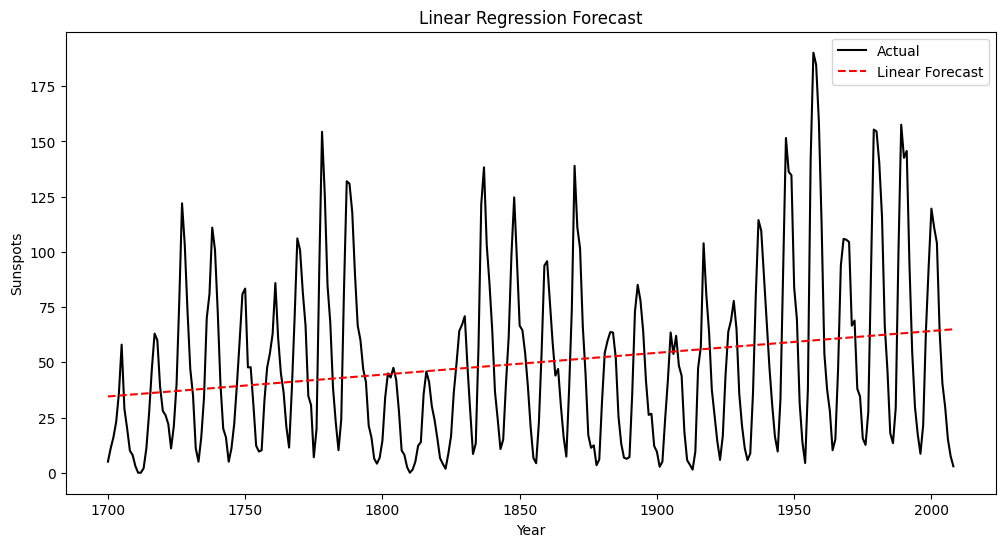

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(sunspot['SUNACTIVITY'], label='Actual', color='black')
plt.plot(sunspot['Linear_Forecast'], label='Linear Forecast', color='red', linestyle='--')
plt.title('Linear Regression Forecast')
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.legend()
plt.show()

## 예제 6-3. 부트스트랩 예시

### 애플 주가 데이터 부트스트랩

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 애플(AAPL) 주식 데이터 가져오기

In [19]:
start_date = "2018-01-01"
end_date = "2023-12-31"

stock = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/AAPL_stock.csv", index_col=0)
stock = stock.loc[start_date:end_date]
stock.index = pd.to_datetime(stock.index)
stock

,close,close_raw,open,high,low,tvol,tamt,sign
date,,,,,,,,
2018-01-02,40.4799,172.26,39.9864,40.4893,39.7749,25555900.0,4.379070e+09,2
2018-01-03,40.4728,172.23,40.5433,41.0180,40.4094,29517900.0,5.155500e+09,5
2018-01-04,40.6608,173.03,40.5457,40.7642,40.4376,22434600.0,3.881270e+09,2
2018-01-05,41.1238,175.00,40.7572,41.2107,40.6655,23660000.0,4.134190e+09,2
2018-01-08,40.9710,174.35,40.9710,41.2671,40.8723,20567800.0,3.591790e+09,5
...,...,...,...,...,...,...,...,...
2023-12-22,192.4450,193.60,194.0150,194.2440,191.8190,37149600.0,7.210780e+09,5
2023-12-26,191.8980,193.05,192.4550,192.7330,191.6790,28919300.0,5.586840e+09,5
2023-12-27,191.9970,193.15,191.3420,192.3450,189.9500,48087700.0,9.262920e+09,2


#### 종가 데이터 추출

In [28]:
stock = stock[['close']]
stock['Naive_Forecast'] = stock.loc[:,'close'].shift(1)
stock['Residuals'] = stock.loc[:,'close'].diff(1)

#### 부트스트랩

In [30]:
np.random.seed(0)  
n_days = 100
n_simulations = 100  
last_value = stock['close'].iloc[-1]

simulations = pd.DataFrame(index=range(n_days), columns=range(n_simulations))

for sim in range(n_simulations):
    simulated_values = [last_value]
    for day in range(1, n_days):
        simulated_values.append(simulated_values[day-1] + np.random.choice(stock['Residuals'].dropna()))
    simulations[sim] = simulated_values

percentiles = [80, 95]
lower_bounds = simulations.quantile(q=(1-percentiles[0]/100)/2, axis=1)
upper_bounds = simulations.quantile(q=1-(1-percentiles[0]/100)/2, axis=1)
lower_bounds_95 = simulations.quantile(q=(1-percentiles[1]/100)/2, axis=1)
upper_bounds_95 = simulations.quantile(q=1-(1-percentiles[1]/100)/2, axis=1)

#### 시각화

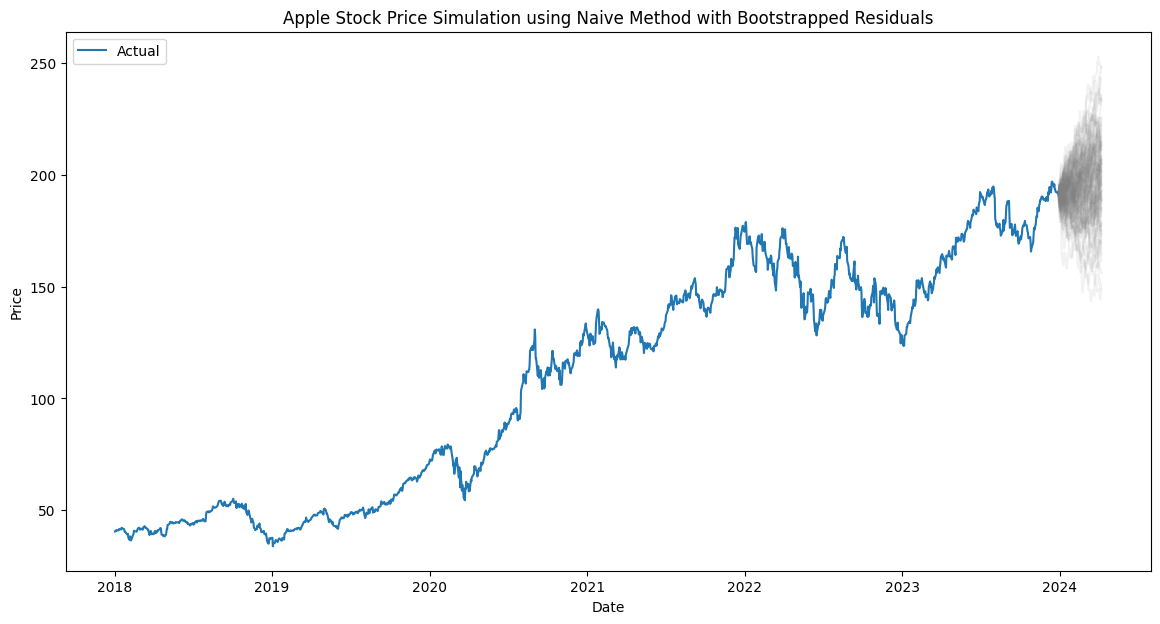

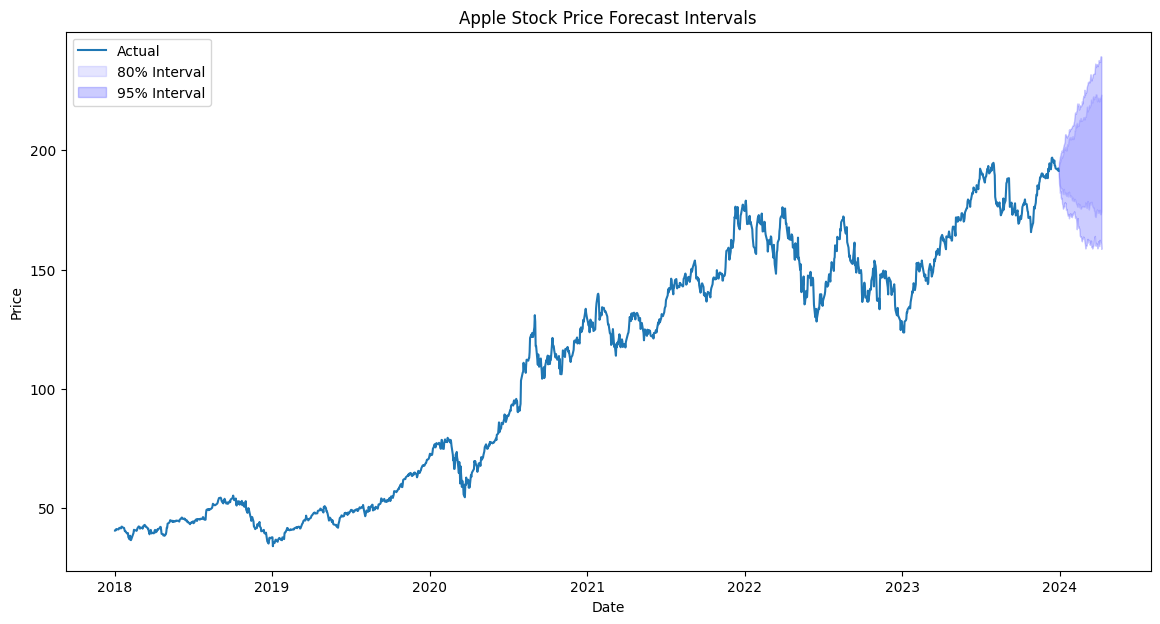

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(stock.index, stock['close'], label='Actual')
for sim in simulations.columns:
    plt.plot(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), simulations[sim], alpha=0.1, color='grey')
plt.title('Apple Stock Price Simulation using Naive Method with Bootstrapped Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(stock.index, stock['close'], label='Actual')
plt.fill_between(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds, upper_bounds, color='blue', alpha=0.1, label=f'{percentiles[0]}% Interval')
plt.fill_between(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds_95, upper_bounds_95, color='blue', alpha=0.2, label=f'{percentiles[1]}% Interval')
plt.title('Apple Stock Price Forecast Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 예제 6-4. 푸리에 변환 예시

### 소매 판매량 데이터 푸리에 변환

#### 필요한 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf

#### 데이터 전처리

In [ ]:
retail = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/example_retail_sales.csv")  
retail['ds'] = pd.to_datetime(retail['ds'])
retail['y'] = retail['y'].str.replace(",", "").astype(float)
retail.set_index('ds', inplace=True)
retail

#### 주기 P 자동 탐색

In [ ]:
P = np.argmax(acf(np.log(retail["y"]).dropna(), nlags=24))
if P == 0:
    P = 12 
print(f"Detected Periodicity (P): {P} months")

#### 푸리에 변환 특성 생성 함수

In [ ]:
def create_fourier_features(t, P, K):
    X = np.ones((len(t), 2*K+2))
    X[:, -1] = t
    for k in range(1, K+1):
        X[:, 2*k-1] = np.sin(2 * np.pi * k * t / P)
        X[:, 2*k] = np.cos(2 * np.pi * k * t / P)
    return X

#### 푸리에 변환

In [ ]:
def fit_fourier_series(df, K, P):
    
    df = df.copy()
    dt = df[:-48].copy()

    t = np.arange(len(dt))
    X = create_fourier_features(t, P, K)
    y = np.log(dt["y"])  
    model = OLS(y, X).fit()
    
    dt["fitted"] = np.exp(model.predict(X)) * np.exp(y.mean() - model.predict(X).mean())

    future_t = np.arange(len(dt), len(dt) + 48)
    X_future = create_fourier_features(future_t, P, K)
    forecast = np.exp(model.predict(X_future)) * np.exp(y.mean() - model.predict(X_future).mean())
    adjustment_factor = dt["fitted"].iloc[-1] / forecast[0]
    forecast_adjusted = forecast * adjustment_factor

    future_dates = pd.date_range(dt.index[-1] + pd.DateOffset(months=1), periods=48, freq='M')
    
    return dt, forecast_adjusted, future_dates

#### 푸리에 예측 및 시각화

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i, K in enumerate(range(1, 7)):  
    modified_df, forecast, future_dates = fit_fourier_series(retail, K, P)

    ax = axes[i]
    ax.plot(retail.index, retail['y'], label='Actual', color='black')
    ax.plot(modified_df.index, modified_df['fitted'], label=f'Fourier(K={K})', color='red', linestyle="dashed")
    ax.plot(future_dates, forecast, label='Forecast', color='blue', linestyle="dotted")

    ax.set_title(f'Fourier Transform Prediction (K={K})')
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Turnover")

plt.tight_layout()
plt.show()

## 예제 6-5. 추세 모델링 예시

### 소매 판매 데이터 결정론적 추세 모델링

#### 필요한 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

#### 데이터 전처리

In [ ]:
retail = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/example_retail_sales.csv")  
retail['ds'] = pd.to_datetime(retail['ds'])
retail['y'] = retail['y'].str.replace(",", "").astype(float)
start_date = retail['ds'].min()
retail['Time'] = (retail['ds'] - start_date) / np.timedelta64(1, 'm')

#### 모델 피팅

In [ ]:
y = np.log(retail['y'])
X = add_constant(retail['Time'])
model = OLS(y, X).fit()

#### 추세 예측

In [ ]:
retail['Fitted'] = model.predict(X)
retail['Exp_Fitted'] = np.exp(retail['Fitted'])

#### 시각화

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(retail['ds'], retail['y'], label='Actual')
plt.plot(retail['ds'], retail['Exp_Fitted'], label='Fitted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Retail Sales – Exponential Trend Regression')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
residuals = y - retail['Fitted']
plt.plot(retail['ds'], residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Retail Sales – Exponential Trend Residual Plot')
plt.legend()
plt.show()

## 예제 6-6. 계절성 모델링 예시

### 대기 이산화탄소 농도 데이터 계절성 모델링

#### 필요한 패키지 불러오기

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates
import statsmodels.api as sm

#### 데이터 불러오기

In [ ]:
co2 = sm.datasets.co2.load_pandas().data
co2 = co2.resample('QE').mean()
co2 = co2[co2.index >= '1981-01-01']
co2['Quarter'] = co2.index.quarter
co2['Year'] = co2.index.year
co2

,co2,Quarter,Year
1981-03-31,340.269231,1,1981
1981-06-30,342.492308,2,1981
1981-09-30,338.500000,3,1981
1981-12-31,338.215385,4,1981
1982-03-31,341.569231,1,1982
...,...,...,...
2000-12-31,368.200000,4,2000
2001-03-31,371.253846,1,2001
2001-06-30,373.200000,2,2001
2001-09-30,369.407692,3,2001


#### 시계열 분해

In [82]:
decomposition = seasonal_decompose(co2['co2'], model='additive', period=4)

#### 분해 시각화

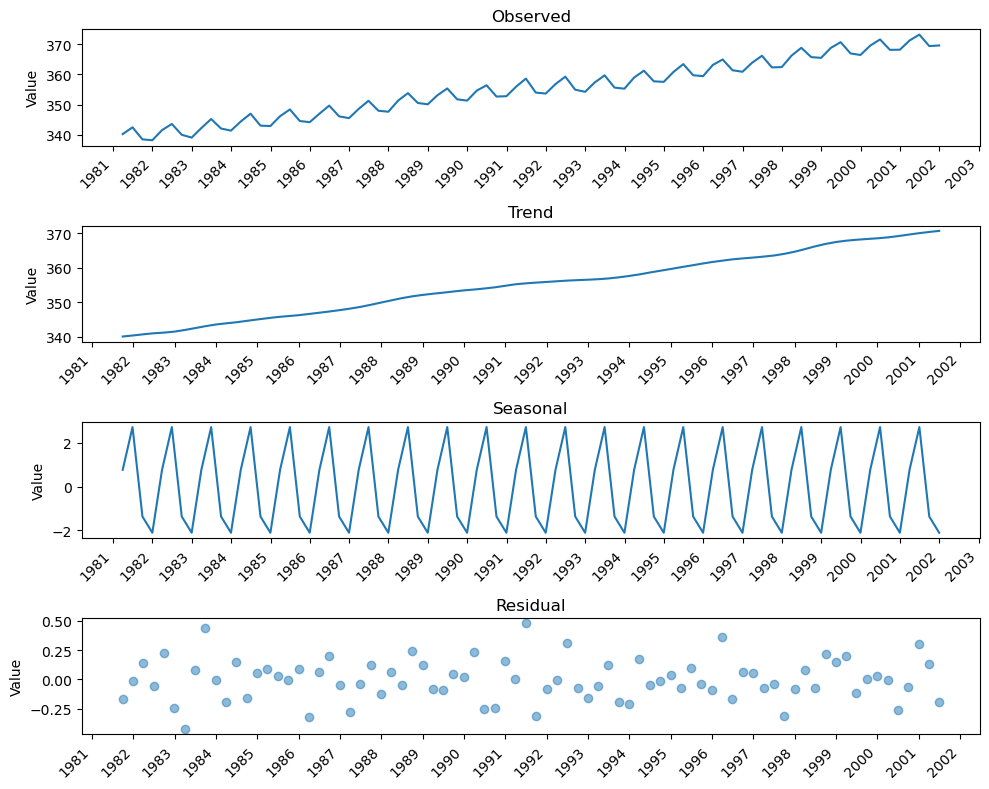

In [83]:
fig, ax = plt.subplots(4, 1, figsize=(10, 8))

ax[0].plot(decomposition.observed)
ax[0].set_title('Observed', fontsize=12)
ax[0].set_ylabel('Value')

ax[1].plot(decomposition.trend)
ax[1].set_title('Trend', fontsize=12)
ax[1].set_ylabel('Value')

ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal', fontsize=12)
ax[2].set_ylabel('Value')

ax[3].scatter(co2.index, decomposition.resid, alpha=0.5)
ax[3].set_title('Residual', fontsize=12)
ax[3].set_ylabel('Value')

ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[2].xaxis.set_major_locator(mdates.YearLocator())
ax[3].xaxis.set_major_locator(mdates.YearLocator())

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for axis in ax:
    plt.setp(axis.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### 계절성 더미 변수 추가

In [126]:
co2_dummies = pd.get_dummies(co2.Quarter)
co2_dummies = co2_dummies.astype(int)
co2_dummies.index = co2.index

#### 모델 피팅 (더미 변수 추가)

In [ ]:
sarima_model = ARIMA(co2['co2'][:-8], exog=co2_dummies.iloc[:-8], order=(1, 1, 1), seasonal_order=(1, 0, 1, 4))
sarima_results = sarima_model.fit()
residuals = sarima_results.resid

#### 잔차 시각화

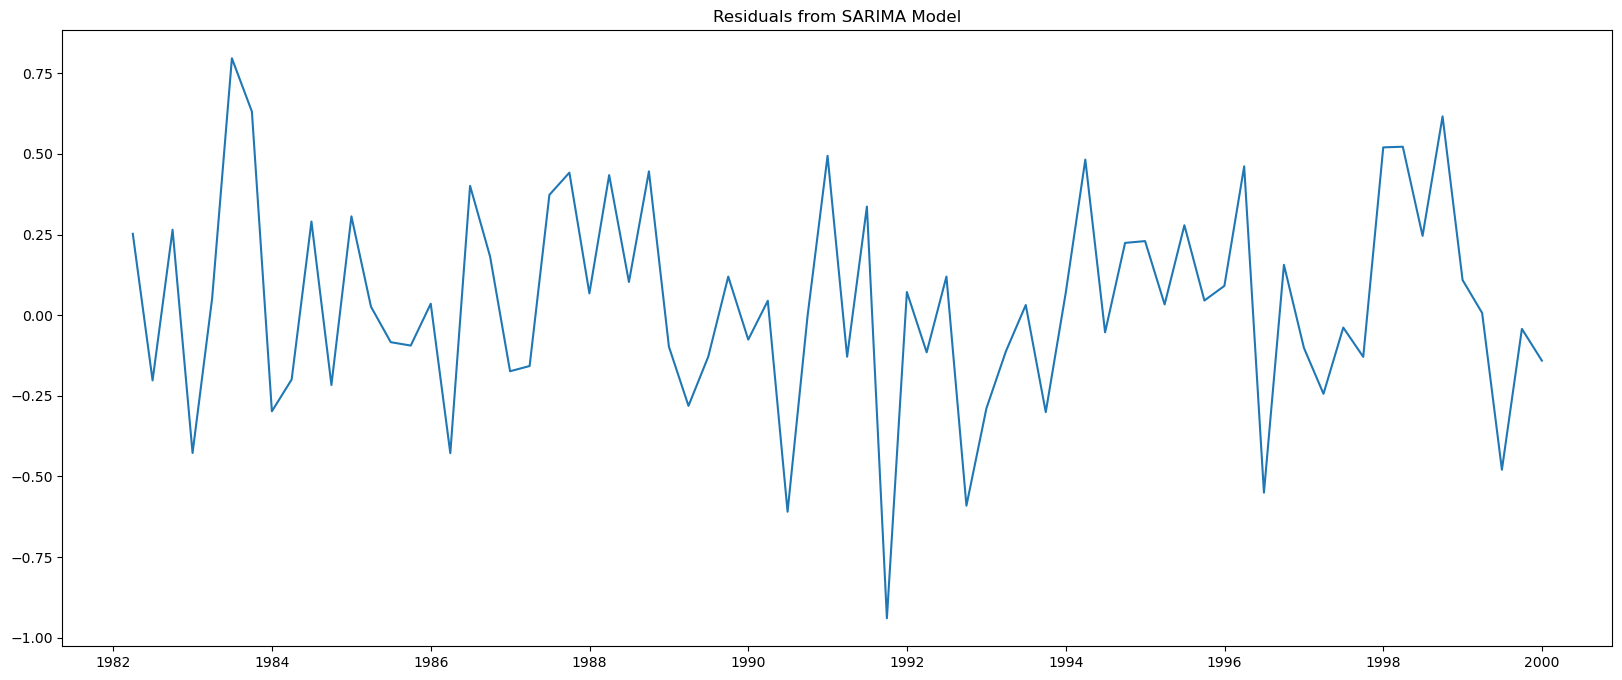

<Figure size 2000x800 with 0 Axes>

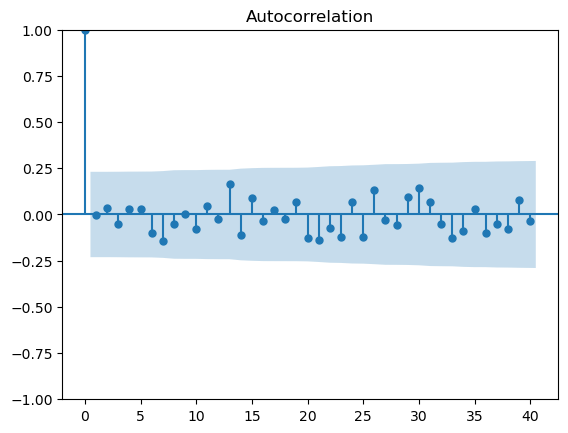

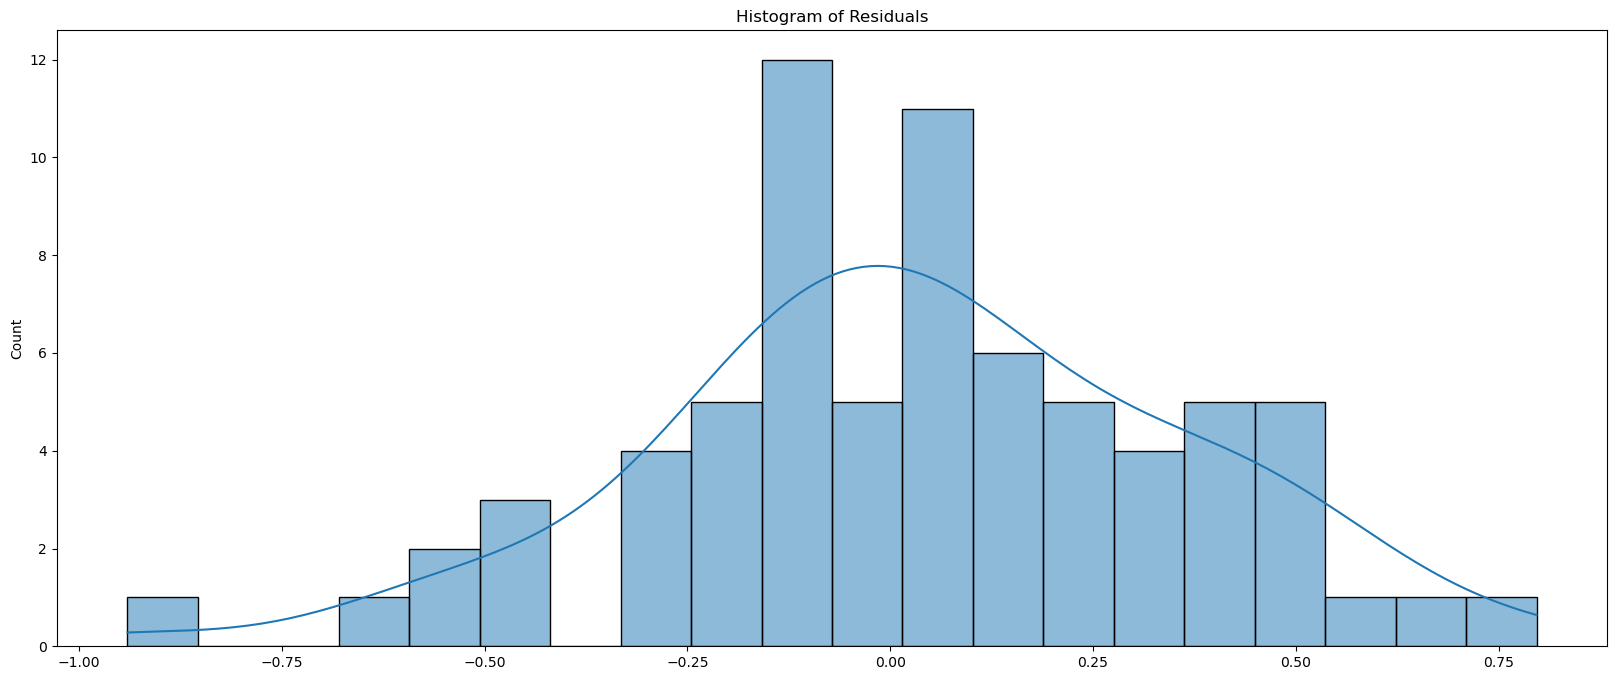

In [130]:
plt.figure(figsize=(20, 8))
plt.plot(residuals[4:])
plt.title('Residuals from SARIMA Model')
plt.show()

plt.figure(figsize=(20, 8))
plot_acf(residuals[4:], lags=40)
plt.show()

plt.figure(figsize=(20, 8))
sns.histplot(residuals[4:], bins=20, kde=True)
plt.title('Histogram of Residuals')
plt.show()

#### 모델 시각화

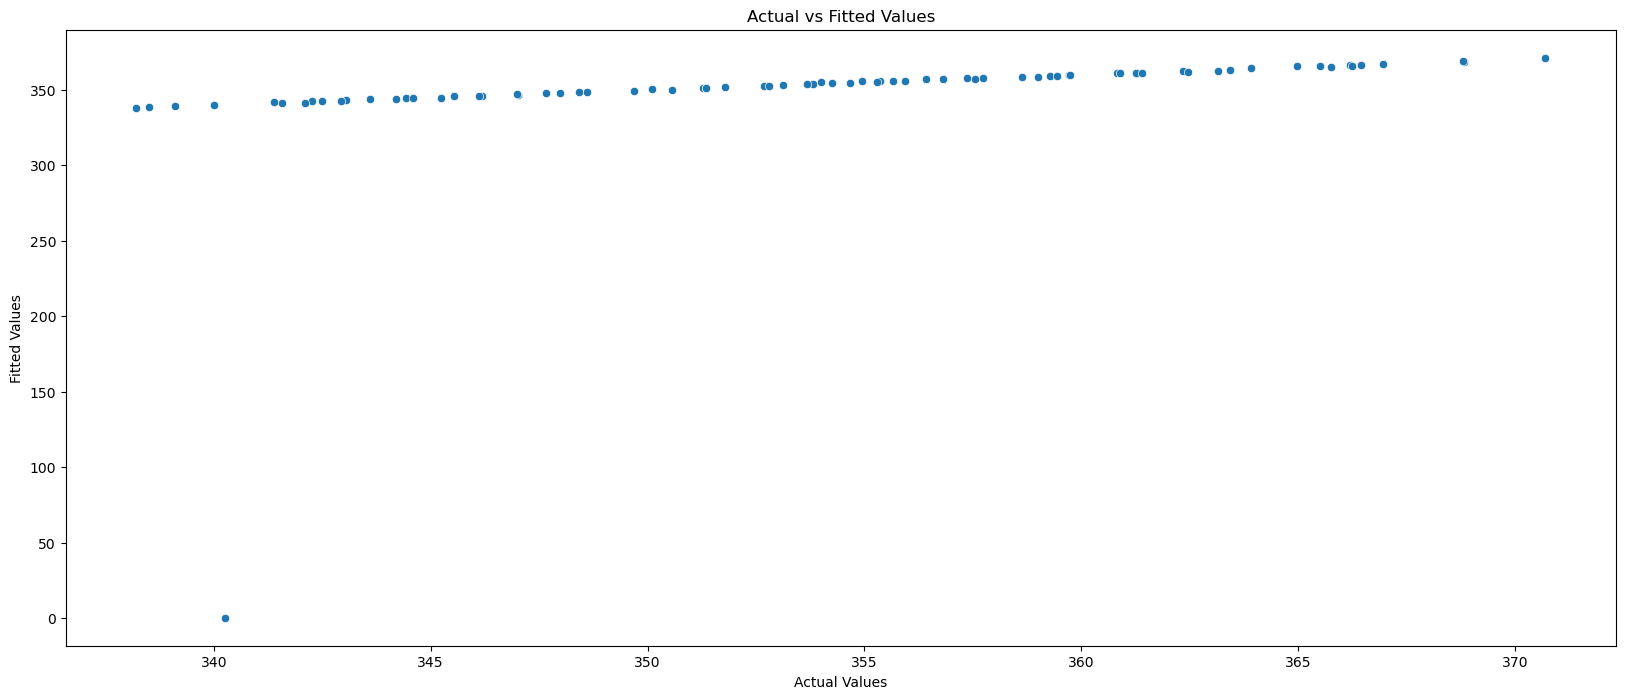

In [131]:
fitted_values = sarima_results.fittedvalues
plt.figure(figsize=(20, 8))
sns.scatterplot(x=co2['co2'], y=fitted_values)
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.title('Actual vs Fitted Values')
plt.show()

#### 예측 시각화

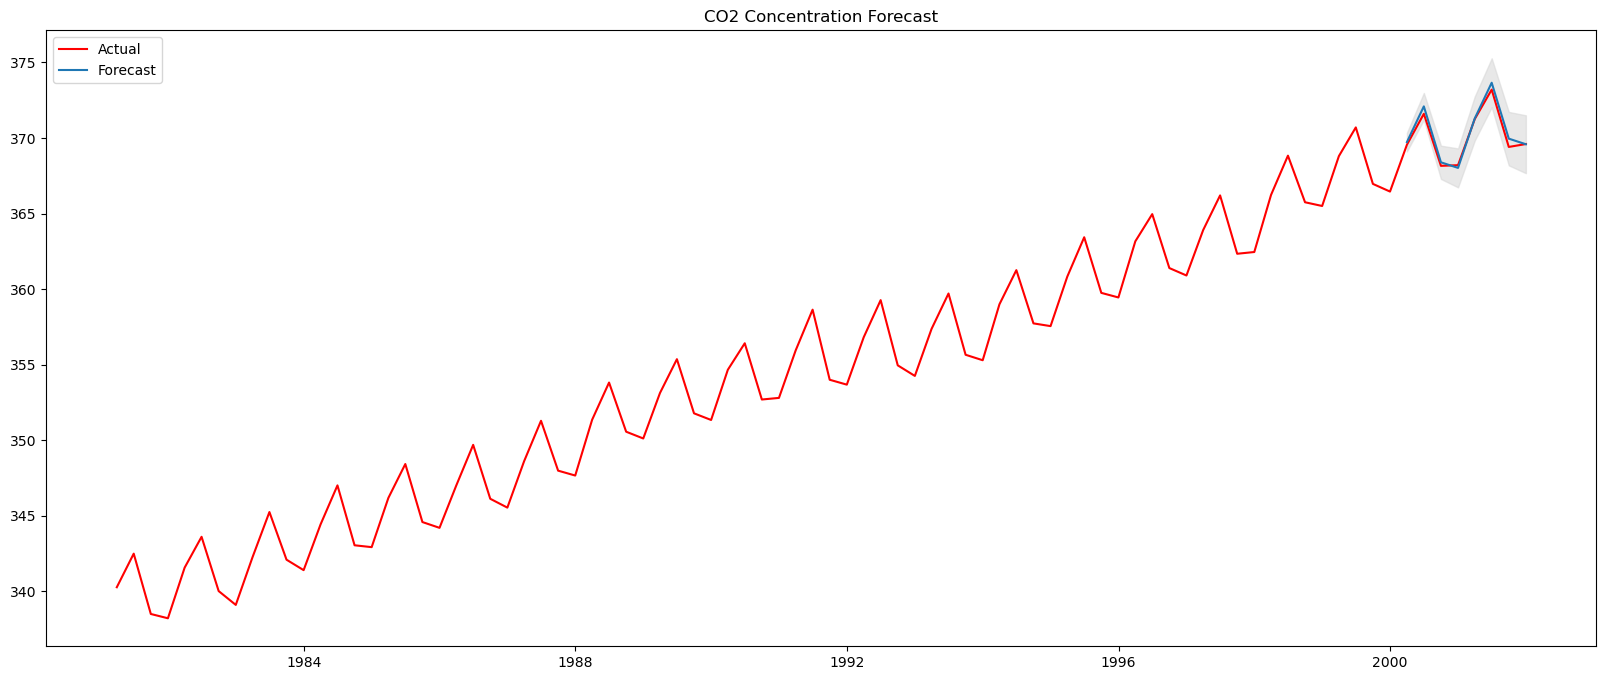

In [132]:
forecast = sarima_results.get_forecast(steps=8, exog=co2_dummies.iloc[-8:])
forecast_ci = forecast.conf_int()

plt.figure(figsize=(20, 8))
plt.plot(co2.index, co2['co2'], label='Actual', color='red')
plt.plot(forecast_ci.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgrey', alpha=0.5)
plt.title('CO2 Concentration Forecast')
plt.legend()
plt.show()